Enter 0 to use default value or 1 to use own
0
31.25   0.96616
29.955983045321158   0.96476
28.76487163431434   0.9634
27.66485998193315   0.962
26.64588167053364   0.9606
25.699300699300696   0.95924
24.81766612641815   0.95784
23.994515539305297   0.95648
23.224216380181996   0.95508
22.50183688464364   0.95372
21.823040380047505   0.95232
21.183998155406965   0.95096
20.581317204301076   0.94956
20.01197996079286   0.94816
19.473293768546   0.9468
18.96284829721363   0.9454
18.478479485116658   0.94404
18.018238870366744   0.94264
17.580367393800238   0.94128
17.1632729310667   0.93988
16.765510948905117   0.93852
16.385767790262182   0.93712
16.022846180676677   0.93576
15.675652619007007   0.93436
15.343186372745501   0.93296
15.024529844644329   0.9316
14.718840115347657   0.9302
14.42534149788037   0.92884
14.143318965517254   0.92744
13.8721123357995   0.92608
13.611111111111123   0.92468
13.35974989094083   0.92332
13.117504283266717   0.92192
12.883887252839727   0.92052
12.6

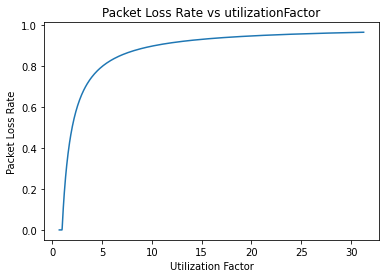

In [4]:
import matplotlib.pyplot as plt
import queue as Q

# Simulating for fixed time
# EVENTS0 = generation of packet
# EVENTS1 = reaching Queue time
# EVENTS2 = leaving queue time
# EVENTS3 = reaching sink time
    
# class for source
class SOURCEINFO:
    def __init__(self, lamda, sid, bandSoSwi):
        self.genRate = lamda        # Here we have taken the generation rate as lamda as given
        self.sourceId = sid         # Every Source has a unique source id
        self.bandSoSwi = bandSoSwi  # It is the bandwidth of source to switch

# class for switch
class SWITCHINFO:
    def __init__(self, bwidth):
        self.bandSwSin = bwidth     # It is the bandwidth of switch to sink
        self.qSize = 0              # Initally in the class we take the size as 0
        

# class for packet
class PACKETINFO:
    def __init__(self, pid=0, gtime=0.0, sourceid=0):
        self.packetId = pid         # We define every packet with a unique packet id
        self.queueIn = -1           # The time the packet gets in the queue
        self.queueOut = -1          # The time the packet gets out of the queue
        self.sourceId = sourceid    # The sourceid of the source from where the packet was generated
        self.generationTime = gtime # The time it was generated
        


# class for various EVENTS
class EVENTS:
    def __lt__(self, other):
        return self.currentTime < other.currentTime
        
    def __init__(self, eid, pid, t):
        self.eId = eid
        self.pId = pid
        self.currentTime = t

utilization = 0   #It measures the utilility
packetDrop = 0    # It will calculate the no of packet drop

# function to avg packet loss rate
# now as we have taken the queue size to be fixed
# So after a particular no of entries the queue will stop the entering of packets w=even if the sourse is sending them
# Now the graph we need is the packet ross vs utilisation factor
# In our utilisation factor the arrival rate and packet length is fixed
# Therefore the only factor that our loss will depend on is the transmission speed
# The greater the transmission speed the less teh utility factor and less is the packet drop rate

def avgPacketLossFunction(nSource, bandSoSwi, bandSwSin, pktLength, source,simulationTime,fixQueueSize):
    packet = []                   # It will contain the information about all the packets
    switchInt = SWITCHINFO(bandSwSin) # declares a variable of the class SWITCHINFO with given bandwidth
    
    # We will generate first packet from every source at an fixed interval
    totaltime = 0.0

    # now we declare a priority queue
    # It adjusts the objects acording to the current time of the events
    pq = Q.PriorityQueue()
    
    global packetDrop
    packetDrop = 0
    
    # We will iterate for all the sources 
    for i in range(nSource):
        packet.append(PACKETINFO(i, totaltime, i))  # We record all the information about our pavket in our packet array
        pq.put(EVENTS(0, i, totaltime))
        totaltime += 0.000001

    pktTot = nSource      
    lastLeftTime = 0.0
    currentTime = 0
    executionTime=0.0
    packet_arrived = 0
    packet_sink = 0
    
    #We will iterate the loop until the pkt reaching sink is not gretaer than the simulation time
    while (currentTime < simulationTime):
        topPacket = pq.get()
        pid = topPacket.pId
        currentTime = topPacket.currentTime
        
        # EVENTS 0 -> (EVENTS0,EVENTS1)
        # first we see for our event 0->1 ie genration of packet and reaching the queue
        # here we take the rate of generation rate lamda and then append in packet array the details of the packet
        # after that we increment totalpackets with 1 and we populate our priority queue for the record
        # At last we give our queue the data of current time + our packetlength/ bandwidth of that stage
        if topPacket.eId == 0:
            rate = source[packet[pid].sourceId].genRate
            pq.put(EVENTS(0, pktTot, currentTime + 1 / rate))
            packet.append(PACKETINFO(pktTot, currentTime + 1 / rate, packet[pid].sourceId))
            pktTot += 1
            flagSoSwi = pktLength / bandSoSwi
            pq.put(EVENTS(1, pid, currentTime + flagSoSwi))
            packet[pid].queueIn = currentTime + flagSoSwi
            
        # EVENTS 1 -> EVENTS2
        # now for event 1->2 ie entering to leaving the queue
        # we first increment the arrived packets by 1
        # then we see if our queue has reached the upper limit or not
        # if yes then we simply drop the packet 
        # but if no then we enter the information about the packet in our priority queue 
        # such as the reaching time and the additional time for the packet since the last packet left
         
        elif topPacket.eId == 1:
            packet_arrived += 1
            if(switchInt.qSize<=fixQueueSize):
            	reachTime = switchInt.qSize*pktLength
            	reachTime = reachTime/bandSwSin
            	addTime = 0
            	flag1 = pktLength/bandSwSin
            	if packet[pid].queueIn - lastLeftTime < flag1:
                	addTime = max(0, flag1 - (packet[pid].queueIn - lastLeftTime))
            	if lastLeftTime == 0:
               	 	addTime = 0
            	pq.put(EVENTS(2, pid, currentTime + reachTime + addTime))
            	packet[pid].queueOut = currentTime + reachTime + addTime
            	switchInt.qSize += 1
            else:
            	packetDrop += 1
            
        # EVENTS2 -> EVENTS3
        # thsi is for event2->3 ie leaving the queue and reaching teh sink
        # first we decrease the queue size by 1 as the packet is now not in the queue
        # Then according to the time and packet id, and bandwidth we popuate our sink recahing time in the prioirty queu
        elif topPacket.eId == 2:
            switchInt.qSize = switchInt.qSize - 1
            lastLeftTime = currentTime
            flag2 = pktLength / bandSwSin
            sinkTime = currentTime + flag2
            pq.put(EVENTS(3, pid, sinkTime))
            
        # thsis for the last stage where the packet reaches the sink
        # here we now update the value of packet reaching the sink
        else:
        	packet_sink += 1

	# packet drop Rate is simply the total no of Packets drop divided by the total no of Packets Arrived
    dropLoss = packetDrop / packet_arrived
    return dropLoss


def main():

    print ("Enter 0 to use default value or 1 to use own")
    resp = int(input())
    if resp == 0:
        # nsource = number of source
        nSource = 5

        # bandSoSwi = bandwidth between source and switch in bit
        bandSoSwi = 1e2

        # bandSwSin = bandwidth between switch and sink in bit
        bandSwSinHigh = 520
        bandSwSinLow = 12
        # pktLength = size of each packet in bit
        pktLength = 3

        #packetGenerate = packet genrated
        packetGenerate = 25

        #simulation time
        simulationTime = 200
        
        #max queue size in switch
        fixQueueSize = 45
    else :

        nSource = int(input("Enter The Number of Sources :"))
        bandSoSwi = float(input("Enter the bandwdth between the Source and switch(bandSoSwi) in bit:"))
        bandSwSinLow = float(input("Enter the bandwidth(lower bound) between the switch and sink(bandSwSin) in bit:"))
        bandSwSinHigh = float(input("Enter the bandwidth(upper bound) between the switch and sink(bandSwSin) in bit:"))
        pktLength = int(input("Enter the packet length in bit(pktlength) :"))
        packetGenerate = int(input("Enter the packet generation rate(considered same for all) for source:"))
        if pktLength*packetGenerate >= bandSoSwi:
            print("pktLength*packetGenerated should be less than bandwidth Between Source and Switch")
            return 0
        simulationTime =int(input("Enter the Simulation time:"))
        fixQueueSize =int(input("Enter the Queue Size in Switch:"))

    # utilization = numerator of utilization factor i.e arrival rate
    global utilization
    # x and y holds value of delay and utilizationfactor
    x = []
    y = []

    # creating source object
    source = []
    for i in range(nSource):
        source.append(SOURCEINFO(packetGenerate, i, bandSoSwi))
        utilization += packetGenerate

    newbandSwSin = bandSwSinLow
    # varying newbandSwSin i.e bandSwSin for plotting
    while (newbandSwSin<=bandSwSinHigh):
        loadfactor = utilization * pktLength
        loadfactor = loadfactor / newbandSwSin
        packetDropRate = avgPacketLossFunction(nSource, bandSoSwi, newbandSwSin, pktLength, source,simulationTime,fixQueueSize)
        x.append(loadfactor)
        y.append(packetDropRate)
        print(loadfactor, " ", packetDropRate)
        newbandSwSin += (bandSwSinHigh-bandSwSinLow)/980
       
    # plotting curve
    plt.plot(x, y)
    plt.xlabel("Utilization Factor")
    plt.ylabel("Packet Loss Rate")
    plt.title("Packet Loss Rate vs utilizationFactor")
    plt.show()


if __name__ == "__main__":
    main()